

---

#### Note: Throughout the thesis code/notebooks, to reproduce different results and methods, code cells are edited and desired paramteres entered and re-ran. Code is commented out and in at times when we want to use different variables etc, this saves having lots of repeated code clogging up the notebooks. Output from cells is not always maintained.


---





---
# Imports & Installations
---




In [1]:
!pip install tensorflow-io
!pip install pydub
!pip install wget
!pip install tensorflow-addons
!pip install keras_tuner

     |████████████████████████████████| 23.4 MB 1.4 MB/s 
     |████████████████████████████████| 2.1 MB 43.2 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.24.0
    Uninstalling tensorflow-io-gcs-filesystem-0.24.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=159269e2a66a6c95c05da98295a235a85de93de79d660b1eec8b17b43c2e5c55
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.1 MB 4.3 MB/s 
     |████████████████████████████████| 13

In [2]:
from google.colab import drive 
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import pydub
import json
import tensorflow_io as tfio
import wget
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive




---

# Functions


---



In [4]:
def read_audio_as_tensor(f, module, snippet_size, offset, normalized=False, frame_rate=16000):
    """
      Input: podcast audio episode in mp3

        Read with pydub and set to mono
        Extract snippet
        Convert to tf.tensor

      Returns: Normalized tensor audio snippet
    """
    try:
      # Preprocess with pydub
      a = pydub.AudioSegment.from_mp3(f)
      a = a.set_frame_rate(frame_rate)
      a = a.set_channels(1)

      # Stitch snippets of audio (leading N seconds and N seconds from middle)
      # Same input as baseline but needs to be stitched to combat GPU memory
      start1 = a[:(100*1000)]
      start2 = a[(100*1000):(150*1000)]
      midpoint = len(a)//2
      middle1 = a[midpoint : midpoint + (50*1000)]
      middle2 = a[midpoint + (50*1000) : midpoint + (150*1000)]

      # Export audio sample for preprocessing
      f = start1 + start2 + middle1 + middle2
      y = np.array(f.get_array_of_samples())

      if normalized:
          return tf.convert_to_tensor( (np.float32(y) / 2**15), dtype=tf.float32)
      else:
          return tf.convert_to_tensor(y, dtype=tf.float32)

    except Exception as e:
      print(e)
      return None


def create_episode_map(file):
  """ 
    Create a map from IDs -> urls, titles
    The popularity train/test sets don't have the URLs.
    We use the map to get urls for a give episode from the full set in
    podcast_episodes_sb dataset.

    Returns: a map of IDs that exist in both datasets
  """

  data = [json.loads(line) for line in open(file, 'r')]

  map = {}
  for x in data:
    map[x['id']] = (x['url'], x['title'])

  return map

def evaluate_kfold(X, y, model, model_name=None, kfold=None, X_aug=None, y_aug=None, sampling=False, cf_matrix=False, augment=False, strategy=0.5, cf=False):
  """ 
    Master function for training all models with cross validation.
    Auxiliary techinqeus 
    
    Input: Model, data and optional parameters
    Returns : Cross Validated Metric Scores
  """
  np.random.seed(196058)

  cv_scores = {
      'roc_auc':[],
      # 'pr_auc':[],
      'f1_weighted':[],
      'f1_macro':[],
      'accuracy':[],
      'precision':[],
      'recall':[]
  }

  # Define stratified approach
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

  # enumerate the splits and summarize the distributions
  for train_ix, test_ix in kfold.split(X, y):
    # select rows
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    print(X_train.shape, y_train.shape, X_aug.shape, y_aug.shape)

    # summarize train and test composition
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

    if augment==True:
      X_train = np.concatenate((X_train, X_aug), axis=0)
      y_train = np.concatenate((y_train, y_aug), axis=0)
      # print(X_train.shape, y_train.shape)

      train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

      model.fit(X_train, y_train)
    else:
      model.fit(X_train, y_train)

    ## Predict
    y_pred = model.predict(X_test)

    # Compute various metrics
    cv_scores['roc_auc'].append( round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100, 1 ))
    #cv_scores['accuracy'].append( round(metrics.accuracy_score(y_test, y_pred) * 100, 1))
    cv_scores['f1_weighted'].append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 1))
    cv_scores['f1_macro'].append( round(metrics.f1_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['precision'].append( round(metrics.precision_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['recall'].append( round(metrics.recall_score(y_test, y_pred, average='macro') * 100, 1))

    # Optional confusion matrix plotting
    if cf:
      cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
      disp.plot()
      plt.show()


  res = [model_name]
  for x in cv_scores.keys():
    res.append(np.mean(cv_scores[x]))

  return res

def format_pretrained_features(df):

  v2 = np.column_stack([df.id.values, df.trill_embedding.values.tolist()])
  c2 = ['id'] + ['trill{}'.format(i) for i in range(v2.shape[1] - 1)] 
  df2 = pd.DataFrame(v2, df.index, c2)
  df2['label'] = df['label']

  return df2



---

# Read in TRILLSon Pre-trained Audio Embeddings

---



In [5]:
trill_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/pretrained_final_dataset.json", lines=True)

print(trill_df.shape)

(3618, 3)


In [ ]:
trill_df.head(5)

,id,trill_embedding,label
0,0005b4e2-adad-4fab-bcce-7fd65bd17d67,"[-0.5438773036, 0.0037935674, -0.4936779737, -...",0
1,00287f38-ff72-4adf-87f2-8325aa3651e3,"[-0.4827392399, -0.2244028151, -0.4869424701, ...",1
2,002c23d0-cd29-4378-b075-aa7a657b1b57,"[-0.44797149300000005, -0.23329487440000002, -...",1
3,0035c812-bf68-40a2-8c61-80b82a4cf236,"[-0.4465982914, 0.037524193500000004, -0.63198...",0
4,0043b17a-f15f-41e1-850b-bac7f5b99a61,"[-0.4514972866, -0.0652327836, -1.0197277069, ...",0




---

# Import Augmented Data for training set


---



In [6]:
aug_trill_df = pd.read_json("gdrive/MyDrive/thesis/podcast_data/clean_data/aug_pretrained_final_dataset.json", lines=True)

X = np.array(trill_df.id.tolist())
y = np.array(trill_df.label.tolist()).astype('float32')

tf.random.set_seed(34)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X, y):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    print(X_train.shape, X_test.shape, len(X_test.tolist()))

# we precomputed augmented samples beforehand, drop test set augmentation 
aug_trill_df = aug_trill_df[~aug_trill_df.id.isin(X_test.tolist())]

aug_trill_df.shape

(2894,) (724,) 724
(2894,) (724,) 724
(2894,) (724,) 724
(2895,) (723,) 723
(2895,) (723,) 723


(2929, 3)



---

# Evaluate Pretrained Audio features w/ Sequential Model
## -Same cross validation as traditional approach
## - NOTE: The 5CV results are printed as a list at the end of each ouput cell in the format of:
     - [model_name, AUROC, f1_weighted, f1_macro, precision, recall

---



In [7]:
import tensorflow_addons as tfa
np.random.seed(5)

X = np.array(trill_df.trill_embedding.tolist()).astype('float32')
Y = np.array(trill_df.label.tolist()).astype('float32')
Y = Y.reshape((Y.shape[0], -1))

X_aug = np.array(aug_trill_df.trill_embedding.tolist()).astype('float32')
Y_aug = np.array(aug_trill_df.label.tolist()).astype('float32')
Y_aug = Y_aug.reshape((Y_aug.shape[0], -1))



---


# 1. Baseline Sequential Network


---


## - note augmentation etc can be applied via the params in the evaluate_kfold

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3072,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model

tf.random.set_seed(34)
estimator = KerasClassifier(build_fn=create_baseline, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# results = cross_val_score(estimator, X, Y, cv=kfold, scoring='roc_auc')
kfold_score = evaluate_kfold(X, Y, estimator, X_aug=X_aug, y_aug=Y_aug, augment=False, cf=False)

print(kfold_score)
# print("Baseline Sequential: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2540, 1=354, Test: 0=636, 1=88
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       636
         1.0       0.33      0.01      0.02        88

    accuracy                           0.88       724
   macro avg       0.61      0.50      0.48       724
weighted avg       0.81      0.88      0.82       724

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       635
         1.0       0.50      0.01      0.02        89

    accuracy                           0.88       724
   macro avg       0.69      0.50      0.48       724
weighted avg       0.83      0.88      0.82       724

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
              precision    recall  f1-score   support

         0.0       0.88      0

In [ ]:
print(kfold_score)

[None, 67.78, 53.14, 84.48, 82.24, 84.48]




---


# 2. Baseline model + Augmentation


---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2929, 3072) (2929, 1)
(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2540, 1=354, Test: 0=636, 1=88
>Train: 0=5117, 1=706, Test: 0=636, 1=88


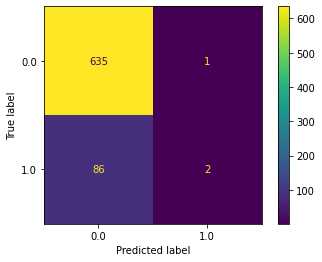

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
>Train: 0=5118, 1=705, Test: 0=635, 1=89


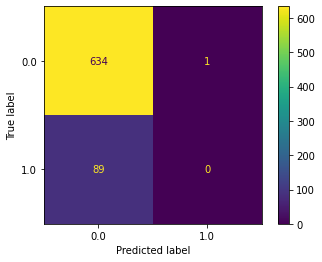

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
>Train: 0=5118, 1=705, Test: 0=635, 1=89


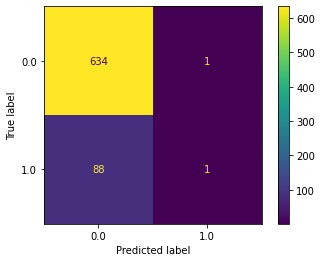

(2895, 3072) (2895, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
>Train: 0=5118, 1=706, Test: 0=635, 1=88


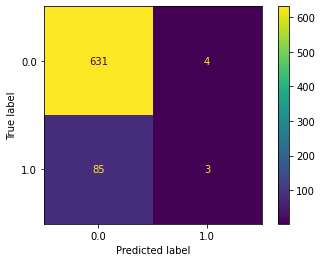

(2895, 3072) (2895, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
>Train: 0=5118, 1=706, Test: 0=635, 1=88


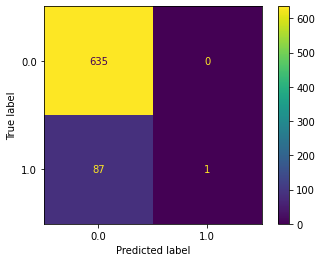

---------------------------------------------
[model_name, AUROC, f1_weighted, f1_macro, precision, recall]
--------------------------------------
[model_name, AUROC, f1_weighted, f1_macro, precision, recall]
['Sequential', 70.17999999999999, 48.260000000000005, 87.8, 83.52000000000001, 87.8]


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3072,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, Y, estimator, model_name='Sequential', X_aug=X_aug, y_aug=Y_aug, cf=True, augment=True)

print(kfold_score)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



---

## 3. Sequential model w/Keras Tuner



---




In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(3072,), dtype=tf.float32, name='input_embedding'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=2048, step=256)
  hp_act = hp.Choice('act', values=['relu', 'linear'])

  model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_act))

  hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  model.add(tf.keras.layers.Dropout(rate=hp_dropout))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

  # model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
  #               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #               metrics=['accuracy'])
  
  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=[tf.keras.metrics.AUC()])

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# obj = kt.Objective("val_roc_auc", direction="max")

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("auc", direction="max"),
                     max_epochs=30,
                     factor=3,
                     seed=42)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
tuner.search(X_aug, y_aug, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
3616              |2592              |units
leakyrelu         |relu              |act
0.9               |0.7               |dropout
0.1               |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



In [ ]:
print(best_hps.get('units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('dropout'))

1024
0.0001
0.4


(2894, 3072) (2894,) (2929, 3072) (2929, 1)
>Train: 0=2540, 1=354, Test: 0=636, 1=88
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       636
         1.0       0.38      0.03      0.06        88

    accuracy                           0.88       724
   macro avg       0.63      0.51      0.50       724
weighted avg       0.82      0.88      0.83       724



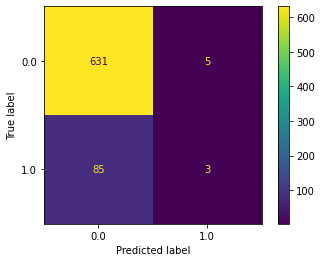

(2894, 3072) (2894,) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       635
         1.0       1.00      0.01      0.02        89

    accuracy                           0.88       724
   macro avg       0.94      0.51      0.48       724
weighted avg       0.89      0.88      0.82       724



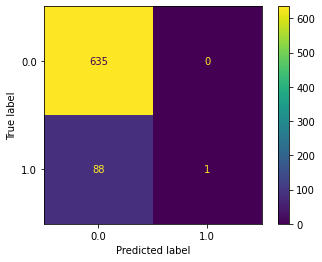

(2894, 3072) (2894,) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       635
         1.0       0.00      0.00      0.00        89

    accuracy                           0.88       724
   macro avg       0.44      0.50      0.47       724
weighted avg       0.77      0.88      0.82       724



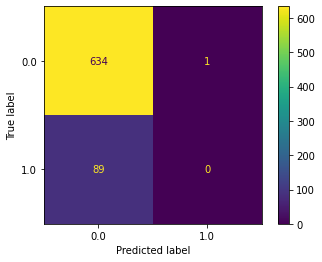

(2895, 3072) (2895,) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       635
         1.0       0.20      0.01      0.02        88

    accuracy                           0.87       723
   macro avg       0.54      0.50      0.48       723
weighted avg       0.80      0.87      0.82       723



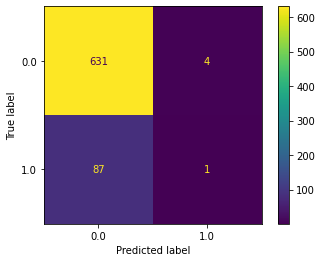

(2895, 3072) (2895,) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.75       635
         1.0       0.16      0.50      0.25        88

    accuracy                           0.63       723
   macro avg       0.53      0.57      0.50       723
weighted avg       0.81      0.63      0.69       723



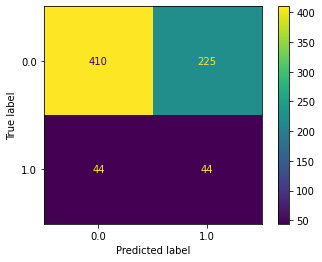

---------------------------------------------
[model_name, AUROC, f1_weighted, f1_macro, precision, recall]
--------------------------------------
[None, 67.34, 48.419999999999995, 82.64, 61.54, 51.88000000000001]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

def create_tuned():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3072,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model

tf.random.set_seed(34)
estimator = KerasClassifier(build_fn=create_tuned, epochs=5, batch_size=64, verbose=20)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

kfold_score = evaluate_kfold(X, y, estimator, X_aug=X_aug, y_aug=Y_aug, augment=False, cf=True)
print(kfold_score)

# results = cross_val_score(estimator, X, Y, cv=kfold, scoring='roc_auc')
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



---

# 4. Tuned + Aug


---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2929, 3072) (2929, 1)
(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2540, 1=354, Test: 0=636, 1=88
>Train: 0=5117, 1=706, Test: 0=636, 1=88
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       636
         1.0       0.37      0.59      0.46        88

    accuracy                           0.83       724
   macro avg       0.65      0.73      0.68       724
weighted avg       0.87      0.83      0.84       724



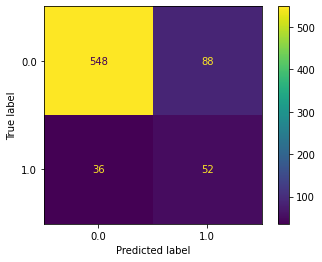

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
>Train: 0=5118, 1=705, Test: 0=635, 1=89
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       635
         1.0       0.76      0.33      0.46        89

    accuracy                           0.90       724
   macro avg       0.84      0.66      0.70       724
weighted avg       0.89      0.90      0.89       724



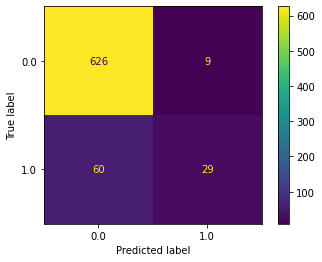

(2894, 3072) (2894, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=353, Test: 0=635, 1=89
>Train: 0=5118, 1=705, Test: 0=635, 1=89
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       635
         1.0       0.61      0.48      0.54        89

    accuracy                           0.90       724
   macro avg       0.77      0.72      0.74       724
weighted avg       0.89      0.90      0.89       724



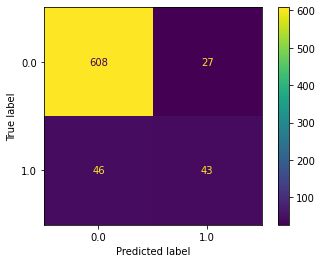

(2895, 3072) (2895, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
>Train: 0=5118, 1=706, Test: 0=635, 1=88
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94       635
         1.0       0.71      0.23      0.34        88

    accuracy                           0.89       723
   macro avg       0.81      0.61      0.64       723
weighted avg       0.88      0.89      0.87       723



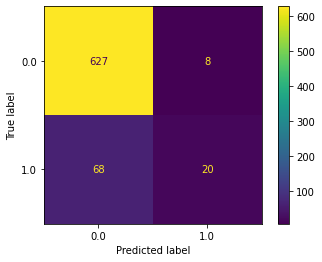

(2895, 3072) (2895, 1) (2929, 3072) (2929, 1)
>Train: 0=2541, 1=354, Test: 0=635, 1=88
>Train: 0=5118, 1=706, Test: 0=635, 1=88
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       635
         1.0       0.23      0.08      0.12        88

    accuracy                           0.85       723
   macro avg       0.55      0.52      0.52       723
weighted avg       0.80      0.85      0.82       723



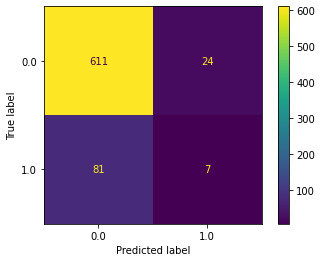

---------------------------------------------
[model_name, AUROC, f1_weighted, f1_macro, precision, recall]
--------------------------------------
['Sequential', 77.12, 65.67999999999999, 87.66, 72.53999999999999, 64.6]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_tuned():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3072,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_tuned, epochs=150, batch_size=64, verbose=0)
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# results = cross_val_score(estimator, X, Y, cv=kfold, scoring='roc_auc')
print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, Y, estimator, model_name='Sequential', X_aug=X_aug, y_aug=Y_aug, augment=True, cf=True)

print(kfold_score)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>



---


# Overfitting



---



## This cell is rerun with different parameters for different experiments

(2894,) (2929,)
(2929,)
Epoch 1/150
91/91 [==============================] - 1s 8ms/step - loss: 0.9498 - auc_2: 0.5339 - val_loss: 0.3691 - val_auc_2: 0.6427
Epoch 2/150
91/91 [==============================] - 0s 5ms/step - loss: 0.5990 - auc_2: 0.5424 - val_loss: 0.4768 - val_auc_2: 0.6393
Epoch 3/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4409 - auc_2: 0.5854 - val_loss: 0.3547 - val_auc_2: 0.6538
Epoch 4/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4067 - auc_2: 0.5906 - val_loss: 0.3508 - val_auc_2: 0.6668
Epoch 5/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3826 - auc_2: 0.6138 - val_loss: 0.3566 - val_auc_2: 0.6595
Epoch 6/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3780 - auc_2: 0.5967 - val_loss: 0.3558 - val_auc_2: 0.6579
Epoch 7/150
91/91 [==============================] - 0s 4ms/step - loss: 0.3671 - auc_2: 0.6146 - val_loss: 0.3493 - val_auc_2: 0.6701
Epoch 8/150
91/91 [============

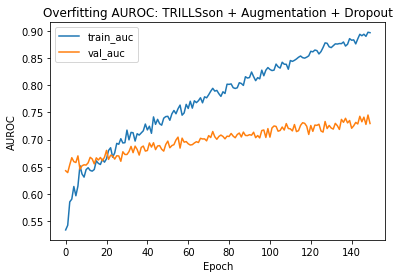

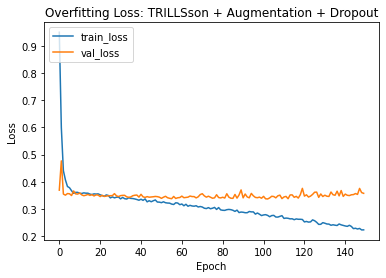

In [10]:
tf.random.set_seed(34)

# fig, ax = plt.subplots()

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# Metrics and plotting

val_loss, val_auc = [], []
train_loss, train_auc = [], []

augment=True
x = 0
for train, test in kfold.split(X, y):
  # if x == 1:
  #   break
  X_train, y_train = X[train], y[train]
  X_test, y_test = X[test], y[test]


  Y_aug = np.reshape(Y_aug, (Y_aug.shape[0],)) 

  if augment:
    X_train = np.concatenate((X_train, X_aug))
    y_train = np.concatenate((y_train, Y_aug))

  X_train = np.asarray(X_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  y_train = np.asarray(y_train).astype('float32')
  y_test = np.asarray(y_test).astype('float32')


  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3072,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(1, activation='sigmoid')])
  
  # class_weight = {0: 1, 1: 100.}

  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])

  history = model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=64, epochs=150)
  print(history.history.keys())
  # summarize history for auc - plotting code modified from online
  plt.plot(history.history['auc_2'])
  plt.plot(history.history['val_auc_2'])
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.title('Overfitting AUROC: TRILLSson + Augmentation + Dropout')
  plt.ylabel('AUROC')
  plt.xlabel('Epoch')
  plt.legend(['train_auc', 'val_auc'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Overfitting Loss: TRILLSson + Augmentation + Dropout')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train_loss', 'val_loss'], loc='upper left')
  plt.show()

  x+=1